#### **Rivaldo Lumelino, Alexandr Voronovich**
#### **CSC 36000 – Updated Final Project**

In [31]:
import random
import math
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from IPython.display import Video, display

# GLOBAL CONSTANTS 
POS_HISTORY = 5          # memory window for neighbor position smoothing
SAFE_RADIUS = 3.0        # "too close" distance (units ~ meters)
EMERGENCY_SPEED = 0.8    # speed used during emergency avoidance
MAX_STALE_STEPS = 10     # messages older than this (in steps) are dropped as stale

# Task-related locations
PICKUP_LOCATIONS = [(10, 10), (40, 40)]
DROP_LOCATIONS   = [(10, 40), (40, 10)]
GOAL_RADIUS = 2.0        # how close counts as "reached" pickup/drop-off

#### **AGENT CLASS**

In [32]:
class Agent:
    def __init__(self, agent_id, x, y):
        self.id = agent_id
        self.x = x
        self.y = y
        self.vx = 0.0
        self.vy = 0.0

        # Communication-based knowledge
        self.known_positions = {}      # sender_id -> smoothed (x, y)
        self.position_memory = {}      # sender_id -> deque([(x, y), ...])

        # Local sensing (backup when no messages)
        self.sensor_range = 5.0
        self.received_current_step = []

        # Interpretability
        self.logs = []                 # list of (time, text)
        self.prev_vx = 0.0
        self.prev_vy = 0.0

        # For metrics
        self.interpret_events = 0      # how many explanatory events we logged
        self.sensor_fallbacks = 0      # how many times we used only sensors

        # Task state machine
        # IDLE -> GO_TO_PICKUP -> GO_TO_DROPOFF -> IDLE -> ...
        self.state = "IDLE"
        self.target = None
        self.carrying = False
        self.tasks_completed = 0

    # basic motion helpers 
    def get_position(self):
        return (self.x, self.y)

    def update_velocity(self):
        """Pick a random new velocity and remember previous one for turn detection."""
        self.prev_vx = self.vx
        self.prev_vy = self.vy
        self.vx = random.uniform(-1, 1)
        self.vy = random.uniform(-1, 1)

    def move(self):
        self.x += self.vx
        self.y += self.vy

    # sensing & communication 
    def sense_agents(self, agents):
        """Local sensors: see neighbors within sensor_range even if messages fail."""
        sensed = []
        for agent in agents:
            if agent.id == self.id:
                continue
            dist = math.dist(self.get_position(), agent.get_position())
            if dist <= self.sensor_range:
                sensed.append((agent.id, agent.get_position()))
        return sensed

    def create_message(self):
        """Message that will be sent to other agents through the network."""
        return {
            "from": self.id,
            "pos": (self.x, self.y),
            "intent": (self.vx, self.vy),
        }

    def receive_message(self, msg):
        """Called by the Network when a message is delivered this step."""
        self.received_current_step.append(msg)

    def closest_point(self, points):
        """Return the closest point from a list of (x,y) points."""
        return min(points, key=lambda p: math.dist(self.get_position(), p))

    def process_received(self, current_time):
        """Smooth incoming positions for each neighbor using a short history window."""
        if not self.received_current_step:
            return

        senders = []

        for msg in self.received_current_step:
            sender = msg["from"]
            pos = msg["pos"]

            # maintain short history of last POS_HISTORY positions per sender
            if sender not in self.position_memory:
                self.position_memory[sender] = deque(maxlen=POS_HISTORY)
            self.position_memory[sender].append(pos)

            xs = [p[0] for p in self.position_memory[sender]]
            ys = [p[1] for p in self.position_memory[sender]]
            avg_pos = (sum(xs) / len(xs), sum(ys) / len(ys))

            self.known_positions[sender] = avg_pos
            senders.append(sender)

        self.logs.append(
            (current_time,
             f"Received messages from agents {sorted(senders)} "
             f"and smoothed their positions.")
        )
        self.interpret_events += 1

        # clear buffer after processing
        self.received_current_step = []

    # decision logic 
    def decide_action(self, current_time, agents):
        """Use comm info + sensors + task state to update velocity."""

        # 1) TASK STATE MACHINE 
        # Always try to keep the state machine running: IDLE -> pickup -> drop -> IDLE -> ...
        if self.state == "IDLE":
            # assign nearest pickup location
            self.target = self.closest_point(PICKUP_LOCATIONS)
            self.state = "GO_TO_PICKUP"
            self.logs.append(
                (current_time, f"New task: go to pickup at {self.target}")
            )
            self.interpret_events += 1
        else:
            # if we have a target, check if we reached it
            if self.target is not None:
                if math.dist(self.get_position(), self.target) < GOAL_RADIUS:
                    # arrived at current target
                    if self.state == "GO_TO_PICKUP":
                        self.carrying = True
                        self.target = self.closest_point(DROP_LOCATIONS)
                        self.state = "GO_TO_DROPOFF"
                        self.logs.append(
                            (current_time,
                             f"Arrived at pickup location, picked up package. "
                             f"Heading to drop-off at {self.target}")
                        )
                        self.interpret_events += 1
                    elif self.state == "GO_TO_DROPOFF":
                        self.carrying = False
                        self.state = "IDLE"
                        self.target = None
                        self.tasks_completed += 1
                        self.logs.append(
                            (current_time,
                             f"Dropped package. Task completed (total={self.tasks_completed}).")
                        )
                        self.interpret_events += 1

        # 2) BASE BEHAVIOR (COMM + SENSORS) 
        if not self.known_positions:
            # No communication → rely on sensors (local backup)
            sensed = self.sense_agents(agents)

            if not sensed:
                # No messages and no neighbors in sensor range → slow down strongly
                old = (self.vx, self.vy)
                self.vx *= 0.2
                self.vy *= 0.2
                self.logs.append(
                    (current_time,
                     f"No messages and no nearby drones → slowed down. "
                     f"Velocity {old} -> ({self.vx:.2f},{self.vy:.2f})")
                )
                self.interpret_events += 1
            else:
                # Sensor-based emergency avoidance: move away from closest neighbor
                closest_id, closest_pos = min(
                    sensed,
                    key=lambda p: math.dist(self.get_position(), p[1])
                )
                cx, cy = closest_pos
                dx = self.x - cx
                dy = self.y - cy
                dist = math.hypot(dx, dy)
                self.sensor_fallbacks += 1

                if dist > 1e-6:
                    away_x = dx / dist
                    away_y = dy / dist
                    old = (self.vx, self.vy)
                    self.vx = away_x * EMERGENCY_SPEED
                    self.vy = away_y * EMERGENCY_SPEED
                    self.logs.append(
                        (current_time,
                         f"Communication failed, using sensors. Closest drone {closest_id} at {closest_pos}. "
                         f"Avoiding: {old} -> ({self.vx:.2f},{self.vy:.2f})")
                    )
                else:
                    # exactly same spot → just slow down
                    old = (self.vx, self.vy)
                    self.vx *= 0.2
                    self.vy *= 0.2
                    self.logs.append(
                        (current_time,
                         f"Drone overlapped with {closest_id}, slowing. "
                         f"{old} -> ({self.vx:.2f},{self.vy:.2f})")
                    )
                self.interpret_events += 1

        else:
            # We have smoothed neighbor positions → swarm behavior:
            #  (a) cohesion: move a bit toward center of mass of neighbors
            #  (b) separation: if too close to any neighbor, repel from it
            ids = list(self.known_positions.keys())
            positions = [self.known_positions[k] for k in ids]

            # cohesion: center of mass
            avg_x = sum(p[0] for p in positions) / len(positions)
            avg_y = sum(p[1] for p in positions) / len(positions)

            # direction to center of mass
            to_cx = avg_x - self.x
            to_cy = avg_y - self.y
            dist_c = math.hypot(to_cx, to_cy)
            if dist_c > 1e-6:
                to_cx /= dist_c
                to_cy /= dist_c

            # separation: repulsive vector away from too-close neighbors
            repel_x = 0.0
            repel_y = 0.0
            for nx, ny in positions:
                dx = self.x - nx
                dy = self.y - ny
                d = math.hypot(dx, dy)
                if d < SAFE_RADIUS and d > 1e-6:
                    # repel stronger when very close
                    strength = (SAFE_RADIUS - d) / SAFE_RADIUS
                    repel_x += (dx / d) * strength
                    repel_y += (dy / d) * strength

            # combine: some attraction to center, plus repulsion
            alpha = 0.25
            beta = 0.75
            desired_vx = alpha * to_cx + beta * repel_x
            desired_vy = alpha * to_cy + beta * repel_y

            # normalize desired vector if too large
            mag = math.hypot(desired_vx, desired_vy)
            if mag > 1e-6:
                desired_vx /= mag
                desired_vy /= mag

            # blend current velocity with desired velocity
            blend = 0.3
            old = (self.vx, self.vy)
            self.vx = (1 - blend) * self.vx + blend * desired_vx
            self.vy = (1 - blend) * self.vy + blend * desired_vy

            self.logs.append(
                (current_time,
                 f"Using neighbor info (ids={sorted(ids)}). "
                 f"Applied attraction+repulsion. {old} -> ({self.vx:.2f},{self.vy:.2f})")
            )
            self.interpret_events += 1

        #  3) GOAL FOLLOWING (TASK) 
        if self.target is not None:
            dx = self.target[0] - self.x
            dy = self.target[1] - self.y
            dist = math.hypot(dx, dy)
            if dist > 1e-6:
                dx /= dist
                dy /= dist
                goal_weight = 0.4
                old = (self.vx, self.vy)
                self.vx = (1 - goal_weight) * self.vx + goal_weight * dx
                self.vy = (1 - goal_weight) * self.vy + goal_weight * dy
                self.logs.append(
                    (current_time,
                     f"Steering toward task goal {self.target}. "
                     f"{old} -> ({self.vx:.2f},{self.vy:.2f})")
                )
                self.interpret_events += 1

        # 4) LARGE-TURN INTERPRETABILITY 
        dv = math.hypot(self.vx - self.prev_vx, self.vy - self.prev_vy)
        if dv > 0.7:
            self.logs.append(
                (current_time,
                 f"Large turn detected (Δv={dv:.2f}). "
                 f"({self.prev_vx:.2f},{self.prev_vy:.2f}) -> ({self.vx:.2f},{self.vy:.2f})")
            )
            self.interpret_events += 1

        # update last velocity
        self.prev_vx = self.vx
        self.prev_vy = self.vy

#### **NETWORK CLASS**

In [33]:
class Network:
    def __init__(self, network_type):
        self.network_type = network_type

        # Communication profiles
        if network_type == "v2x":
            # Almost perfect, near-real-time
            self.drop_prob = 0.01
            self.delay_range = (1, 1)
        elif network_type == "mqtt":
            # IoT style: more delay and loss
            self.drop_prob = 0.10
            self.delay_range = (3, 8)
        elif network_type == "urban":
            self.drop_prob = 0.05
            self.delay_range = (1, 3)
        elif network_type == "suburban":
            self.drop_prob = 0.10
            self.delay_range = (2, 6)
        elif network_type == "rural":
            self.drop_prob = 0.30
            self.delay_range = (5, 15)
        else:
            raise ValueError("Invalid network_type")

        # (deliver_time, recipient_agent, msg)
        self.queue = []
        self.time = 0

        # Metrics
        self.comm_success = 0
        self.comm_attempts = 0
        self.total_delivery_delay = 0
        self.delivery_events = 0
        self.dropped_stale = 0
        self.collisions = 0

    def broadcast(self, sender, msg, agents):
        """Sender broadcasts a message that might be delayed/dropped."""
        for agent in agents:
            if agent.id == sender.id:
                continue

            self.comm_attempts += 1

            # random drop
            if random.random() < self.drop_prob:
                continue

            # attach send time
            msg2 = dict(msg)
            msg2["sent_at"] = self.time

            delay = random.randint(*self.delay_range)
            deliver_time = self.time + delay
            self.queue.append((deliver_time, agent, msg2))

    def deliver_messages(self):
        """Deliver messages whose time has come; drop stale ones."""
        new_queue = []
        for deliver_time, agent, msg in self.queue:
            age = self.time - msg.get("sent_at", self.time)

            if deliver_time <= self.time:
                if age <= MAX_STALE_STEPS:
                    agent.receive_message(msg)
                    self.comm_success += 1
                    self.total_delivery_delay += age
                    self.delivery_events += 1
                else:
                    # too old → stale
                    self.dropped_stale += 1
            else:
                new_queue.append((deliver_time, agent, msg))
        self.queue = new_queue

#### **ENVIRONMENT CLASS**

In [34]:
class Environment:
    def __init__(self, num_agents, network_type, steps=100):
        self.agents = [
            Agent(i, random.uniform(0, 50), random.uniform(0, 50))
            for i in range(num_agents)
        ]
        self.network = Network(network_type)
        self.steps = steps
        self.logs = {}   # step -> list of (agent_id, time, text)

    def check_collisions(self):
        """Simple collision checker: if two agents share rounded (x,y)."""
        positions = {}
        for agent in self.agents:
            pos = (round(agent.x, 1), round(agent.y, 1))
            if pos in positions:
                self.network.collisions += 1
            else:
                positions[pos] = agent.id

    def run_step(self, step):
        """Run a single simulation step (used by both run and visualization)."""
        # 1) motion proposal
        for agent in self.agents:
            agent.update_velocity()

        # 2) communication
        for agent in self.agents:
            msg = agent.create_message()
            self.network.broadcast(agent, msg, self.agents)

        # 3) network delivers messages
        self.network.deliver_messages()

        # 4) agents process comm
        for agent in self.agents:
            agent.process_received(self.network.time)

        # 5) agents decide based on comm + sensors + tasks
        for agent in self.agents:
            agent.decide_action(self.network.time, self.agents)

        # 6) agents move
        for agent in self.agents:
            agent.move()

        # 7) collision check
        self.check_collisions()

        # 8) collect logs
        step_logs = []
        for agent in self.agents:
            for (t, text) in agent.logs:
                step_logs.append((agent.id, t, text))
            agent.logs = []
        self.logs[step] = step_logs

        # 9) advance network time
        self.network.time += 1

    def run(self):
        """Run full simulation for self.steps steps."""
        for step in range(1, self.steps + 1):
            self.run_step(step)

            # periodic console logging every 10 steps
            if step % 10 == 0:
                avg_delay = (
                    self.network.total_delivery_delay / self.network.delivery_events
                    if self.network.delivery_events > 0 else 0.0
                )
                delivery_rate = (
                    self.network.comm_success / self.network.comm_attempts
                    if self.network.comm_attempts > 0 else 0.0
                )
                print(
                    f"[step {step}] time={self.network.time} "
                    f"queue={len(self.network.queue)} "
                    f"comm_success={self.network.comm_success}/{self.network.comm_attempts} "
                    f"collisions={self.network.collisions} "
                    f"avg_delay={avg_delay:.2f} "
                    f"delivery_rate={delivery_rate:.2f}"
                )

        # metrics
        avg_delay = (
            self.network.total_delivery_delay / self.network.delivery_events
            if self.network.delivery_events > 0 else 0.0
        )
        delivery_rate = (
            self.network.comm_success / self.network.comm_attempts
            if self.network.comm_attempts > 0 else 0.0
        )

        sensor_fallbacks = sum(a.sensor_fallbacks for a in self.agents)
        interpret_events = sum(a.interpret_events for a in self.agents)
        tasks_completed = sum(a.tasks_completed for a in self.agents)

        return {
            "network_type": self.network.network_type,
            "steps": self.steps,
            "agents": len(self.agents),
            "comm_success": self.network.comm_success,
            "comm_attempts": self.network.comm_attempts,
            "collisions": self.network.collisions,
            "avg_delay": avg_delay,
            "delivery_rate": delivery_rate,
            "sensor_fallbacks": sensor_fallbacks,
            "interpret_events": interpret_events,
            "dropped_stale": self.network.dropped_stale,
            "tasks_completed": tasks_completed,
            "logs": self.logs,
        }

#### **COMPARISON FUNCTION (5 MODES)**

In [35]:
def run_all_networks(num_agents=100, steps=50):
    modes = ["v2x", "mqtt", "urban", "suburban", "rural"]
    results_table = []

    print("\n=== Running all network modes ===\n")

    for mode in modes:
        random.seed(42)  # same seed for fair comparison
        env = Environment(num_agents=num_agents, network_type=mode, steps=steps)
        r = env.run()
        results_table.append(r)

    # pretty print
    print("\n====== NETWORK COMPARISON TABLE ======")
    header = (
        f"{'Mode':<10} | {'DelivRate':<10} | {'AvgDelay':<8} | "
        f"{'Collisions':<10} | {'SensorFB':<9} | {'ExplainEv':<10} | "
        f"{'Dropped':<8} | {'Tasks':<6}"
    )
    print(header)
    print("-" * len(header))
    for r in results_table:
        print(
            f"{r['network_type']:<10} | "
            f"{r['delivery_rate']:<10.2f} | "
            f"{r['avg_delay']:<8.2f} | "
            f"{r['collisions']:<10d} | "
            f"{r['sensor_fallbacks']:<9d} | "
            f"{r['interpret_events']:<10d} | "
            f"{r['dropped_stale']:<8d} | "
            f"{r['tasks_completed']:<6d}"
        )

    return results_table

#### **DEMO / MAIN**

In [36]:
if __name__ == "__main__":
    random.seed(42)
    # Run a single demo simulation (e.g. rural)
    env = Environment(num_agents=8, network_type="rural", steps=50)
    results = env.run()

    print("\n=== SINGLE RUN SUMMARY (rural) ===")
    print(f"Network type:      {results['network_type']}")
    print(f"Total steps:       {results['steps']}")
    print(f"Agents:            {results['agents']}")
    print(f"Messages sent:     {results['comm_attempts']}")
    print(f"Messages received: {results['comm_success']}")
    print(f"Delivery rate:     {results['delivery_rate']:.2f}")
    print(f"Average delay:     {results['avg_delay']:.2f} steps")
    print(f"Collisions:        {results['collisions']}")
    print(f"Sensor fallbacks:  {results['sensor_fallbacks']}")
    print(f"Interpret events:  {results['interpret_events']}")
    print(f"Dropped stale:     {results['dropped_stale']}")
    print(f"Tasks completed:   {results['tasks_completed']}")

    # Print sample interpretability logs for first 5 steps
    print("\n=== SAMPLE INTERPRETABILITY LOGS (first 5 steps) ===")
    for t in range(1, 6):
        entries = results["logs"].get(t, [])
        print(f"\nTime step {t}, {len(entries)} events")
        for (agent_id, tick, text) in entries[:5]:
            print(f"[Agent {agent_id}] {text}")

    # Comparison of all 5 network modes
    run_all_networks(num_agents=8, steps=50)


[step 10] time=10 queue=333 comm_success=57/560 collisions=0 avg_delay=6.53 delivery_rate=0.10
[step 20] time=20 queue=406 comm_success=271/1120 collisions=0 avg_delay=7.20 delivery_rate=0.24
[step 30] time=30 queue=390 comm_success=479/1680 collisions=0 avg_delay=7.34 delivery_rate=0.29
[step 40] time=40 queue=387 comm_success=704/2240 collisions=0 avg_delay=7.35 delivery_rate=0.31
[step 50] time=50 queue=404 comm_success=902/2800 collisions=0 avg_delay=7.39 delivery_rate=0.32

=== SINGLE RUN SUMMARY (rural) ===
Network type:      rural
Total steps:       50
Agents:            8
Messages sent:     2800
Messages received: 902
Delivery rate:     0.32
Average delay:     7.39 steps
Collisions:        0
Sensor fallbacks:  0
Interpret events:  1202
Dropped stale:     673
Tasks completed:   0

=== SAMPLE INTERPRETABILITY LOGS (first 5 steps) ===

Time step 1, 24 events
[Agent 0] New task: go to pickup at (10, 10)
[Agent 0] No messages and no nearby drones → slowed down. Velocity (-0.55911875

#### **Video**

FileNotFoundError: [WinError 2] The system cannot find the file specified

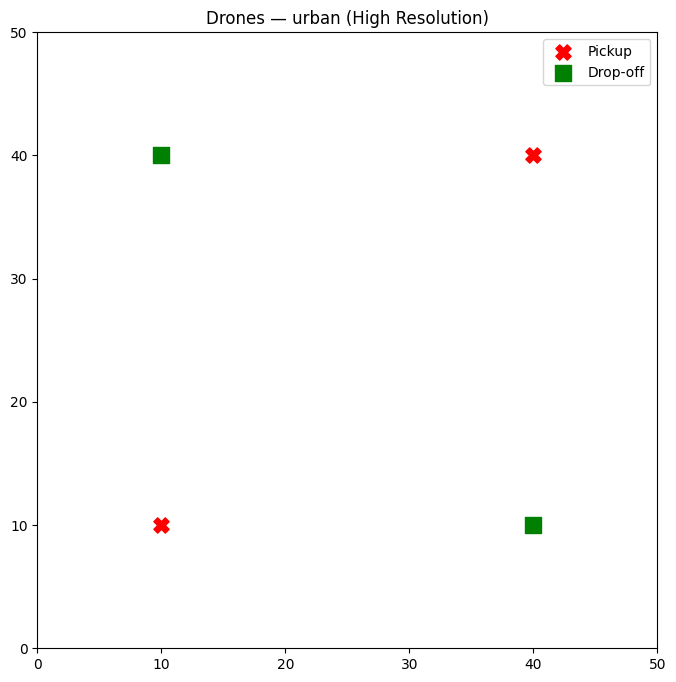

In [37]:
def visualize_as_mp4_highres(network_type="rural",
                             num_agents=50,
                             steps=200,
                             filename="drones_highres.mp4",
                             dpi=200):   # <-- HIGH RESOLUTION CONTROL
    """
    Run a simulation and save a HIGH-RESOLUTION MP4 showing:
    - Drone movement
    - Pickup / Drop-off locations
    - Carrying status colors
    """

    random.seed(42)
    env = Environment(num_agents=num_agents, network_type=network_type, steps=steps)

    # High-resolution figure
    fig, ax = plt.subplots(figsize=(8, 8))   # <-- larger figure → more detail
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.set_title(f"Drones — {network_type} (High Resolution)")

    # Draw pickup & drop-off markers
    px, py = zip(*PICKUP_LOCATIONS)
    dx, dy = zip(*DROP_LOCATIONS)
    ax.scatter(px, py, c="red", marker="X", s=120, label="Pickup")
    ax.scatter(dx, dy, c="green", marker="s", s=120, label="Drop-off")
    ax.legend(loc="upper right", fontsize=10)

    scatter = ax.scatter([], [], s=40)  # larger dots so HD video looks good
    writer = FFMpegWriter(fps=10)       # smoother animation

    with writer.saving(fig, filename, dpi=dpi):
        for frame in range(steps):
            env.run_step(frame + 1)

            positions = [agent.get_position() for agent in env.agents]
            scatter.set_offsets(positions)

            # Color drones orange if carrying, blue if empty
            colors = ["orange" if agent.carrying else "blue" for agent in env.agents]
            scatter.set_color(colors)

            writer.grab_frame()

    plt.close(fig)
    print(f"Saved HIGH-RES video as {filename}")
    return filename


# RUN HIGH-RES VISUALIZATION
mp4_file = visualize_as_mp4_highres(
    network_type="urban",
    num_agents=100,
    steps=300,
    filename="drones_highres.mp4",
    dpi=120         # 200 = 1080p, 120 = 720p
)

display(Video(mp4_file, embed=True))
